In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

from lightgbm import LGBMRegressor

## Load Data

In [2]:
raw_df = pd.read_csv('data/train_house_price.csv')
raw_test = pd.read_csv('data/test_house_price.csv')
X_train = raw_df.iloc[:, :-1].copy()
y_train = raw_df.iloc[:, -1].copy()

## Split into Text or Numerical Features

In [3]:
def get_features(X_train):
    '''Ignore columns with many nulls and split into text or numerical features'''
    cols_w_nulls = X_train.columns[X_train.isnull().mean() > 0.1]
    features_txt = [i for i in X_train.dtypes[X_train.dtypes=='object'].index if i not in cols_w_nulls]
    features_num = [i for i in X_train.dtypes[(X_train.dtypes=='int') | (X_train.dtypes=='float')].index
                   if i not in cols_w_nulls]
    features_num.remove('Id')
    return features_num, features_txt
print([len(f) for f in get_features(X_train)])
# get_features(X_train)[0]

[35, 38]


## Target Mean Encoding

In [4]:
class Target_mean_encoder(TransformerMixin, BaseEstimator):
    '''Do target mean encoding of dataframe. Category replaced with the mean of that category'''
    def __init__(self):
        self.computed_means = None
    def fit(self, X, y):
        self.computed_means = {
            column_name: dict(y.groupby(by=category).mean().iteritems())
            for column_name, category in X.iteritems()
        }
        return self
    def transform(self, X):
        df_out = X.copy()
        for column_name, means in self.computed_means.items():
            for category, mean in means.items():
                df_out[column_name].mask(df_out[column_name]==category, mean, inplace=True)
        # cope with values not in the fitted data
        df_out.replace(r'.*', np.nan, inplace=True, regex=True)
        df_out.fillna(value=df_out.mean(axis=0), inplace=True)
        return df_out.astype('f8')
### test
# num_features, txt_features = get_features(X_train)
# tm_encoder = Target_mean_encoder()
# tm_encoder.fit_transform(X_train[txt_features], y_train)
# blks = tm_encoder.transform(raw_test[txt_features])
# b_fill = blks.fillna(value='XXX')
# b_fill2 = b_fill.replace(r'.*', np.nan, regex=True).astype('f8')
# blks.mean(axis=0)
# fill3 = b_fill2.fillna(value=blks.mean(axis=0))
# fill3['MSZoning'][(fill3['MSZoning']>179806) & (fill3['MSZoning']<179807)]

## One Hot Encoder with Nulls

In [5]:
class Ohe_nulls(TransformerMixin, BaseEstimator):
    '''One hot encoding that can cope with nulls'''
    def __init__(self):
        self.encoder = OneHotEncoder(handle_unknown='ignore')
    def fit(self, X, y):
        df_tmp = X.fillna(value='null_ohe')
        self.encoder.fit(df_tmp, y)
        return self
    def transform(self, X):
        df_tmp = X.fillna(value='null_ohe_tx')
        return self.encoder.transform(df_tmp)

## Pipeline

In [6]:
def create_pipe(model, feature_tuple, ohe=False):
    '''Create scikit-learn pipeline'''
    features_num, features_txt = feature_tuple
    transformed = FeatureUnion([
        ('square', FunctionTransformer(np.square, validate=True)),
        ('sqrt', FunctionTransformer(np.sqrt, validate=True))
    ])
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer()),
        ('transform', transformed),
        ('scaler', MinMaxScaler())
    ])
    txt_pipeline = Pipeline([
        ('encoder', Target_mean_encoder()),
        ('imputer', SimpleImputer()),
        ('scaler', MinMaxScaler())
    ])
    ohe_pipe = FeatureUnion([
        ('tm_enc', txt_pipeline),
        ('ohe', Ohe_nulls())
    ])
    if ohe:
        txt_encoder = ohe_pipe
    else:
        txt_encoder = txt_pipeline
    ctx = ColumnTransformer([
        ('numbers', numerical_pipeline, features_num),
        ('txt', txt_encoder, features_txt)
    ])
    model = Pipeline([
        ('columns', ctx),
        ('model', model)])
    return model


## Test Model

In [7]:
def test_model(model, X_train, y_train):
    '''Do cross-validation of model'''
    cv = KFold(n_splits=5, shuffle=True, random_state=192)
    cv_results = cross_validate(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, return_train_score=True)
    return pd.DataFrame(cv_results)

## Try Single Model

In [8]:
%%time
s_model = create_pipe(LinearRegression(), get_features(X_train), ohe=False)
df_results = test_model(s_model, X_train, y_train)
df_results

CPU times: user 12.6 s, sys: 984 ms, total: 13.6 s
Wall time: 4.52 s


,fit_time,score_time,test_score,train_score
0,0.397764,0.259277,-19800.059364,-15155.925606
1,0.365311,0.241837,-20515.711932,-14741.461613
2,0.356626,0.232626,-18311.856562,-16191.483746
3,0.368152,0.242330,-18560.857607,-15832.929870
4,0.360315,0.240320,-16125.947778,-16481.686380


## Decision Tree - Hyperparameter Tuning

In [9]:
def tuning(model, X_train, y_train, params):
    '''Do hyperparameter tuning'''
    cv = KFold(n_splits=5, shuffle=True, random_state=192)
    grid = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=cv, return_train_score=True)
    grid.fit(X_train, y_train)
    return pd.DataFrame(grid.cv_results_, dtype='float')

In [10]:
# %%time
# dt = DecisionTreeClassifier()
# dt_model = create_pipe(dt, get_features(X_train))
# params = {'model__max_depth': range(2, 15),
#          'model__max_leaf_nodes': range(50, 255, 20)}
# grid_results = tuning(dt_model, X_train, y_train, params)

In [11]:
# grid_results.sort_values(by='mean_test_score', ascending=False)

In [12]:
# plt.scatter(grid_results['param_model__max_leaf_nodes'], grid_results['param_model__max_depth'], c=grid_results['mean_test_score'], cmap='jet', s=90)
# plt.xlabel('num_leaves')
# plt.ylabel('max_depth')
# plt.colorbar().ax.set_ylabel('mean_test_score')

In [13]:
%%time
dt = DecisionTreeClassifier()
dt_model = create_pipe(dt, get_features(X_train))
params = {'model__max_depth': range(2, 8),
         'model__max_leaf_nodes': range(5, 48, 5)}
grid_results2 = tuning(dt_model, X_train, y_train, params)

CPU times: user 11min 16s, sys: 54.6 s, total: 12min 11s
Wall time: 4min 11s


In [14]:
grid_results2.sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
42,0.436175,0.006679,0.227650,0.005776,6.0,35.0,"{'model__max_depth': 6, 'model__max_leaf_nodes...",-33716.938356,-42452.989726,-34551.904110,...,-35196.450685,3750.424596,1.0,-32075.970034,-31547.719178,-31579.648116,-37756.395548,-33906.360445,-33373.218664,2354.938532
43,0.430831,0.009060,0.233784,0.006685,6.0,40.0,"{'model__max_depth': 6, 'model__max_leaf_nodes...",-34171.904110,-42417.030822,-34618.684932,...,-35328.991781,3671.313319,2.0,-32470.107021,-31542.582192,-31637.447774,-37671.595034,-33923.911815,-33449.128767,2277.289255
44,0.437720,0.006562,0.230265,0.006532,6.0,45.0,"{'model__max_depth': 6, 'model__max_leaf_nodes...",-34096.561644,-42459.839041,-34688.890411,...,-35505.704110,3591.317574,3.0,-32416.168664,-31532.898116,-31639.160103,-37756.395548,-33848.997432,-33438.723973,2312.004923
52,0.453982,0.009554,0.240864,0.006354,7.0,40.0,"{'model__max_depth': 7, 'model__max_leaf_nodes...",-33814.027397,-41470.188356,-39979.897260,...,-35648.535616,4309.603914,4.0,-32188.041952,-31448.476027,-36611.866438,-31468.216610,-34948.481164,-33333.016438,2083.291681
51,0.440957,0.013386,0.226826,0.004118,7.0,35.0,"{'model__max_depth': 7, 'model__max_leaf_nodes...",-34346.219178,-41889.291096,-40143.253425,...,-35772.940411,4554.049701,5.0,-33670.062500,-32323.376712,-36860.753425,-31550.802226,-35360.553082,-33953.109589,1946.407739
40,0.429841,0.008812,0.234846,0.008961,6.0,25.0,"{'model__max_depth': 6, 'model__max_leaf_nodes...",-38312.404110,-42310.448630,-36279.047945,...,-35877.886986,4282.626741,6.0,-38045.964897,-31965.818493,-33500.083904,-33184.952911,-34411.263699,-34221.616781,2066.180634
41,0.430976,0.003913,0.234582,0.013868,6.0,30.0,"{'model__max_depth': 6, 'model__max_leaf_nodes...",-35471.219178,-42209.839041,-36188.294521,...,-36273.667123,3381.612928,7.0,-34293.307363,-31951.710616,-33131.025685,-39243.927226,-34170.672945,-34558.128767,2490.260965
53,0.454636,0.007324,0.233168,0.008123,7.0,45.0,"{'model__max_depth': 7, 'model__max_leaf_nodes...",-33019.164384,-41652.989726,-40635.123288,...,-36351.665753,3927.148019,8.0,-31748.834760,-31290.118151,-37266.215753,-34774.944349,-35254.023116,-34066.827226,2246.337163
50,0.441765,0.005131,0.230063,0.006880,7.0,30.0,"{'model__max_depth': 7, 'model__max_leaf_nodes...",-38404.869863,-42450.315068,-41130.520548,...,-36948.075342,4785.350274,9.0,-37584.064212,-32825.260274,-37512.397260,-32106.826199,-35416.460616,-35089.001712,2290.122629
49,0.436116,0.009109,0.226649,0.008331,7.0,25.0,"{'model__max_depth': 7, 'model__max_leaf_nodes...",-39933.636986,-42123.917808,-36465.006849,...,-37057.053425,3532.761804,10.0,-40563.104452,-33240.885274,-33484.758562,-35859.728596,-35649.594178,-35759.614212,2631.144598


Text(0, 0.5, 'mean_test_score')

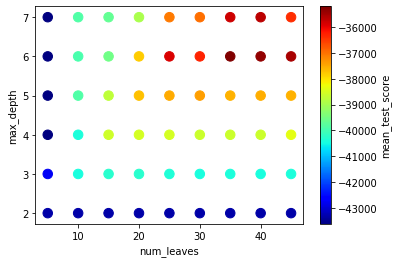

In [15]:
plt.scatter(grid_results2['param_model__max_leaf_nodes'], grid_results2['param_model__max_depth'], c=grid_results2['mean_test_score'], cmap='jet', s=90)
plt.xlabel('num_leaves')
plt.ylabel('max_depth')
plt.colorbar().ax.set_ylabel('mean_test_score')

## Use Gradient Boosted Tree

In [16]:
%%time
lgb = create_pipe(LGBMRegressor(max_depth=6), get_features(X_train), ohe=False)
params = {'model__num_leaves': range(2, 15)}
grid_results3 = tuning(lgb, X_train, y_train, params)

CPU times: user 5min 35s, sys: 31.4 s, total: 6min 6s
Wall time: 1min 7s


In [17]:
grid_results3.sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
5,0.444934,0.005967,0.264963,0.001994,7.0,{'model__num_leaves': 7},-15856.361022,-18824.833423,-16442.482753,-15430.094727,...,-15926.629760,1845.211235,1.0,-10756.781625,-10383.261840,-10777.035396,-11178.278319,-11397.167225,-10898.504881,354.190067
7,0.453788,0.002930,0.264079,0.001076,9.0,{'model__num_leaves': 9},-15970.662379,-19141.899462,-16292.690421,-15158.400049,...,-15944.611883,1934.940820,2.0,-9802.071583,-9638.485662,-9550.261473,-10128.414352,-10622.437591,-9948.334132,390.564978
6,0.448000,0.006655,0.264638,0.000701,8.0,{'model__num_leaves': 8},-16147.481847,-19063.400543,-16763.113517,-15268.496757,...,-16031.117571,2002.386217,3.0,-10292.226820,-9939.709484,-10031.304186,-10521.585875,-11069.676667,-10370.900606,404.582528
10,0.460714,0.006437,0.265966,0.002099,12.0,{'model__num_leaves': 12},-16055.444355,-19472.248198,-16334.960512,-15590.517388,...,-16061.825493,2107.384660,4.0,-9060.959841,-9157.974975,-9115.262249,-9577.551888,-9933.907850,-9369.131361,336.576241
9,0.475170,0.038323,0.266507,0.002324,11.0,{'model__num_leaves': 11},-16213.305901,-18969.029793,-16680.441234,-15739.950803,...,-16085.529290,1971.589615,5.0,-9333.241338,-9281.855644,-9336.039349,-9590.908245,-10150.175257,-9538.443967,324.308800
8,0.452886,0.004572,0.264457,0.001380,10.0,{'model__num_leaves': 10},-15895.401388,-19455.663539,-17048.766280,-15261.501787,...,-16109.860627,2155.097434,6.0,-9364.792248,-9498.772877,-9641.891114,-9761.686356,-10400.849611,-9733.598441,359.328357
4,0.451564,0.028748,0.265922,0.002548,6.0,{'model__num_leaves': 6},-16308.039246,-18939.871681,-16409.527450,-15680.393530,...,-16133.325473,1791.873321,7.0,-11372.789065,-10986.058331,-11415.303185,-11786.634767,-12144.284506,-11541.013971,394.041495
12,0.463649,0.006039,0.267077,0.004092,14.0,{'model__num_leaves': 14},-16169.324957,-19058.678216,-16446.645575,-15748.478855,...,-16182.025691,1777.438408,8.0,-8630.485640,-8905.534101,-8987.119442,-9332.942070,-9937.905527,-9158.797356,449.458513
11,0.458366,0.009044,0.265263,0.002008,13.0,{'model__num_leaves': 13},-16042.994288,-19192.218570,-16729.092273,-15752.685932,...,-16254.489056,1813.109395,9.0,-9072.780637,-9033.550177,-9025.219039,-9211.610066,-9942.838871,-9257.199758,349.291859
3,0.427835,0.004678,0.265111,0.001611,5.0,{'model__num_leaves': 5},-16578.557484,-19631.016927,-16663.087130,-16622.549269,...,-16598.489133,1940.059379,10.0,-11984.787727,-11524.622681,-12314.750454,-12692.546448,-12703.783315,-12244.098125,447.726461


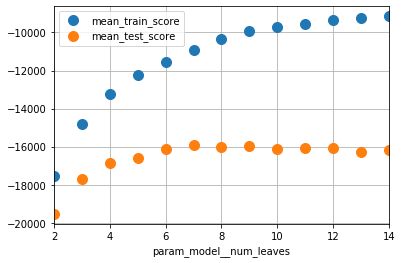

In [18]:
grid_results3[['param_model__num_leaves', 'mean_train_score', 'mean_test_score']].plot(x='param_model__num_leaves', style='o', ms=10)
plt.grid()

In [19]:
%%time
lgb_model = create_pipe(LGBMRegressor(num_leaves=7, max_depth=6), get_features(X_train), ohe=False)
df_results = test_model(lgb_model, X_train, y_train)
df_results

CPU times: user 25 s, sys: 2.52 s, total: 27.5 s
Wall time: 5.12 s


,fit_time,score_time,test_score,train_score
0,0.411931,0.264556,-15856.361022,-10756.781625
1,0.434293,0.263931,-18824.833423,-10383.261840
2,0.442708,0.265225,-16442.482753,-10777.035396
3,0.448000,0.262936,-15430.094727,-11178.278319
4,0.438699,0.263658,-13079.376874,-11397.167225


## Cleanup Test Dataset

In [20]:
feature_names = get_features(X_train)
num_cols, txt_cols = feature_names
X_test = raw_test.copy()
# X_test[txt_cols] = X_test[txt_cols].fillna(value='Unknown')
# for i in num_cols:
#     X_test[i] = X_test[i].fillna(value=X_test[i].mean())

## Prediction

In [21]:
p_model = create_pipe(LGBMRegressor(num_leaves=7, max_depth=6), get_features(X_train), ohe=False)
p_model.fit(X_train, y_train)
# print(p_model.named_steps.model.coef_)
y_pred = p_model.predict(X_test)
y_pred

array([123492.94037116, 163775.36466577, 177051.04226054, ...,
       163393.59337988, 118792.93170192, 203935.78645922])

In [22]:
def do_scatter(x, y, trend=True):
    '''scatter plot with optional trendline'''
    name = x.name
    if not trend:
        # categorical
        categories = y_train.groupby(X_train[name]).mean().sort_values().index
        x = OrdinalEncoder([categories]).fit_transform(x.to_frame())
    sns.regplot(x, y, ci=None, color='C1', fit_reg=trend, scatter_kws={'alpha': .3})
    plt.xlabel(name)
    plt.ylabel('Price (£)')
    if not trend:
        # categorical
        plt.xticks(ticks=range(len(categories)), labels=categories, rotation=90)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

In [23]:
def do_subplots(column_name, trend=True):
    fig, ax = plt.subplots(1, 2, sharex=trend, sharey=True, figsize=(12, 4))
    plt.sca(ax[0])
    do_scatter(X_train[column_name], y_train, trend=trend)
    plt.title('Training Set')
    plt.sca(ax[1])
    do_scatter(X_test[column_name], y_pred, trend=trend)
    plt.title('Test Set Predictions')

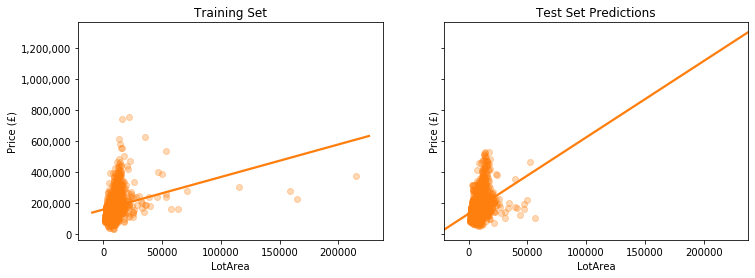

In [24]:
do_subplots('LotArea')

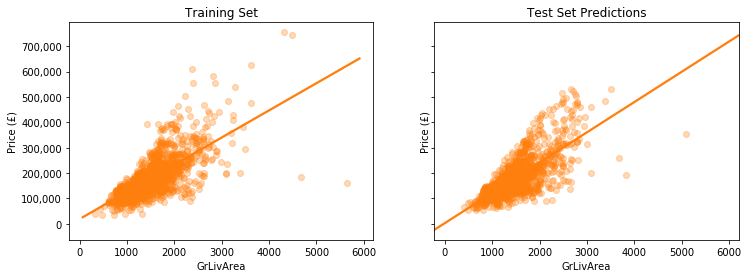

In [25]:
do_subplots('GrLivArea')

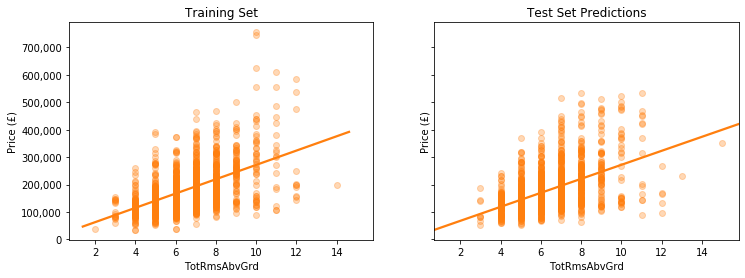

In [26]:
do_subplots('TotRmsAbvGrd')

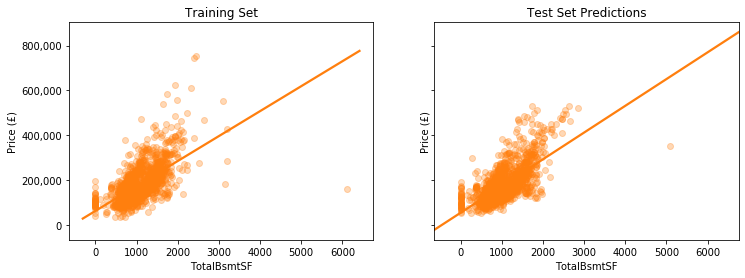

In [27]:
do_subplots('TotalBsmtSF')

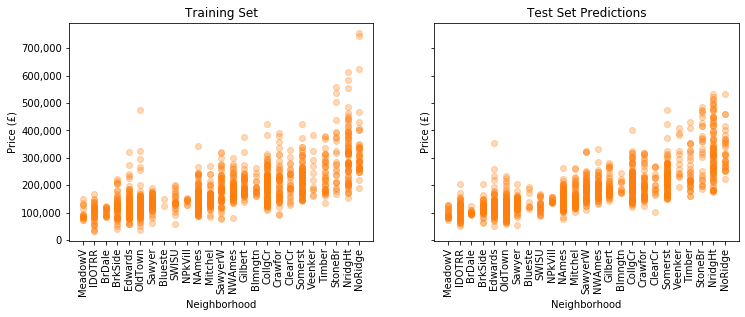

In [28]:
do_subplots('Neighborhood', trend=False)

In [29]:
print(y_pred[X_test['Neighborhood']=='StoneBr'].max())
print(y_train[X_train['Neighborhood']=='StoneBr'].max())

485616.68214763235
556581


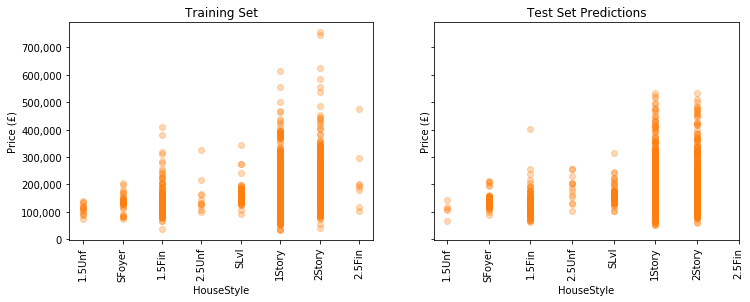

In [30]:
do_subplots('HouseStyle', trend=False)

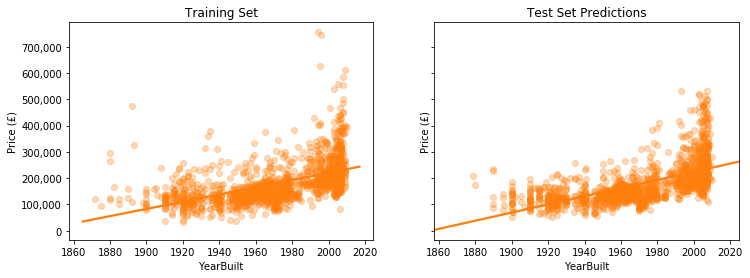

In [31]:
do_subplots('YearBuilt')